In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import sklearn.linear_model as lm
from  sklearn.linear_model import (LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import statsmodels

from itertools import groupby
from operator import itemgetter

import copy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore', category=UserWarning)

## Read datafile

In [2]:
df= pd.read_csv("MTL+PLS.csv", delimiter=";", skipinitialspace=True)
"Datapoints unfiltered"
len(df)

datasets = {}

'Datapoints unfiltered'

558

## Filter dataset

In [3]:
df['order_qty'] = pd.to_numeric(df['order_qty'], errors='coerce')

df = df[df['order_qty'] > 0]
"Datapoints where 'order_qty' > 0"
len(df)

df = df[df['turnover_days'] >= 0]
"Datapoints where 'turnover_days' >= 0"
len(df)

df = df[df['lot_size'].notna()]
"Datapoints where 'lot_size' is not empty"
len(df)

# df = df[df['forecast_error'].notna()]
# "Datapoints where 'forecast_error' is not empty"
# len(df)




"Datapoints where 'order_qty' > 0"

354

"Datapoints where 'turnover_days' >= 0"

305

"Datapoints where 'lot_size' is not empty"

305

## Divide dataset

In [4]:
datasets.update({"slob_only": df[df['turnover_days'] >= 90]})
"df_slob_only item count"
len(datasets["slob_only"])


'df_slob_only item count'

91

### Remove outluers and create new dataset

In [5]:
def remove_outliers(input_df, filter_values):
    # Create an empty DataFrame to store the filtered values
    filtered_values_df = pd.DataFrame()

    # Apply the filters
    for column, quantile in filter_values.items():
        # Find values that are above the quantile
        is_above_quantile = input_df[column] > input_df[column].quantile(quantile)

        # Store these values in the filtered values DataFrame
        filtered_values_df = pd.concat([filtered_values_df, input_df[is_above_quantile]])

        # Remove these values from the original DataFrame
        input_df = input_df[~is_above_quantile]

    # Remove duplicates from the filtered values DataFrame
    filtered_values_df = filtered_values_df.drop_duplicates()

    return input_df, filtered_values_df

In [6]:
# 0.999 Quantile filter values
filter_values_0_999 = {
    "lot_size": 0.999,
    "moq": 0.999,
    "safety_stock": 1,
    "lead_time": 0.999,
    "turnover_days": 1,
    "average_stock_level": 0.999,
    "order_qty": 1,
    "consumption": 1
}

# 0.99 Quantile filter values
filter_values_0_99 = {
    "lot_size": 0.99,
    "moq": 0.99,
    "safety_stock": 1,
    "lead_time": 0.99,
    "turnover_days": 1,
    "average_stock_level": 0.99,
    "order_qty": 1,
    "consumption": 1
}



# slob_only_outliers_removed, slob_only_filtered_values = remove_outliers(datasets["slob_only"], filter_values_0_999)
# print("slob_only_0.999_outliers_removed item count")
# print(len(slob_only_filtered_values))
# datasets.update({"slob_only_0.999_outliers_removed": slob_only_outliers_removed})

# slob_only_outliers_removed, slob_only_filtered_values = remove_outliers(datasets["slob_only"], filter_values_0_99)
# print("slob_only_0.99_outliers_removed item count")
# print(len(slob_only_filtered_values))
# datasets.update({"slob_only_0.99_outliers_removed": slob_only_outliers_removed})


In [ ]:
datasets

In [8]:
# slob_only_filtered_values

## Examine datasets

In [ ]:
for dataset_name, dataset in datasets.items():
    "Current dataset: " + dataset_name
    dataset.describe().apply(lambda s: s.apply('{0:.2f}'.format))


## Visual Inspection and Log Transformation of Average Stock Level Data

In [ ]:

# Temporary dictionary for new datasets
new_datasets = {}

# Histogram and Density plot before transformation
for dataset_name, dataset in datasets.items():
    print("Current dataset: ", dataset_name)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(dataset['average_stock_level'], kde=False, bins=30)
    plt.title('Histogram of Average Stock Level')
    plt.subplot(1, 2, 2)
    sns.kdeplot(dataset['average_stock_level'])
    plt.title('Density Plot of Average Stock Level')
    plt.show()
    
    # Copy the original dataset
    new_dataset = copy.deepcopy(dataset)
    
    # Applying log transformation to 'average_stock_level'
    new_dataset['average_stock_level'] = np.log(new_dataset['average_stock_level'])
    
    # Add the new dataset to the temporary dictionary
    new_datasets[dataset_name + '_log'] = new_dataset
    
    # Histogram and Density plot after transformation
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(new_dataset['average_stock_level'], kde=False, bins=30)
    plt.title('Histogram of Log Transformed Average Stock Level')
    plt.subplot(1, 2, 2)
    sns.kdeplot(new_dataset['average_stock_level'])
    plt.title('Density Plot of Log Transformed Average Stock Level')
    plt.show()

# Update the original dictionary with the new datasets
# datasets.update(new_datasets)

# Replace the original dictionary with the new datasets
datasets = new_datasets



## Examine datasets

In [39]:
list(datasets)

['slob_only_log']

In [ ]:
from IPython.display import display, HTML
display(HTML(new_datasets['slob_only_log'].to_html()))

# Run regression models

In [12]:
list_of_dependant_variables = [
    "average_stock_level"
   
]
list_of_independant_variables = [
    "lot_size",
    "moq",
    "lead_time",
    "safety_stock",
    # "forecast_error"
]

regression_results = []

In [13]:

for dataset_name, dataset in datasets.items():
    for dependent_variable in list_of_dependant_variables:
        for independent_variable in list_of_independant_variables:
            
            X = dataset[[independent_variable]]
            y = dataset[dependent_variable]

            lr = LinearRegression().fit(X, y)

            regression_results.append({
                "dataset": dataset_name,
                "dependent_variable": dependent_variable,
                "independent_variable": independent_variable,
                "regression_model": "linear_regression",
                "regression_result": lr.coef_[0],
                "model": lr,
                "x_min": X.min(),
                "x_max": X.max()
            })

In [14]:

for dataset_name, dataset in datasets.items():
    for dependent_variable in list_of_dependant_variables:
        for independent_variable in list_of_independant_variables:
            
            X = dataset[[independent_variable]]
            y = dataset[dependent_variable]

            huber = HuberRegressor().fit(X, y)

            regression_results.append({
                "dataset": dataset_name,
                "dependent_variable": dependent_variable,
                "independent_variable": independent_variable,
                "regression_model": "huber_regression",
                "regression_result": huber.coef_[0],
                "model": huber,
                "x_min": X.min(),
                "x_max": X.max()
            })

In [ ]:
regression_results

## Visualize regression models

### Visualize all models

In [ ]:


# Group regression results by dataset, dependent_variable, and independent_variable
grouped_results = groupby(sorted(regression_results, key=itemgetter('dataset', 'dependent_variable', 'independent_variable')), key=itemgetter('dataset', 'dependent_variable', 'independent_variable'))

for (dataset_name, dependent_variable, independent_variable), group in grouped_results:

    plt.figure(figsize=(8, 6))

    # Retrieve the original data
    X = datasets[dataset_name][[independent_variable]]
    y = datasets[dataset_name][dependent_variable]
    plt.scatter(X, y, label="Data", alpha=0.3);

    # Plot each regression model for the group
    for result in group:
        plotline_X = np.linspace(result["x_min"], result["x_max"], 100).reshape(-1, 1)
        plotline_y = result["model"].predict(plotline_X)
        plt.plot(plotline_X, plotline_y, label=f"{result['regression_model']} fit");

    plt.title(f"Dataset: {dataset_name},\n" +
              f"Dependent variable: {dependent_variable},\n" +
              f"Independent variable: {independent_variable}"
              );
    plt.xlabel(independent_variable);
    plt.ylabel(dependent_variable);
    plt.legend();
    plt.show();


## Get model statistics

In [19]:
def summary(model, X, y):
    y_pred = model.predict(X)

    print("\n###  Model: " + type(model).__name__ + "  ###")
    # print("--------------")
    # print(type(model).__name__)  # Model name
    # print()

    # Coefficients or important features
    if hasattr(model, "coef_"):
        print(f"Coefficients:\n{model.coef_}")

    # The intercept
    if hasattr(model, "intercept_"):
        print(f"Intercept:\n{model.intercept_}")

    print("---- Performance Metrics:")
    print(f"Mean squared error: {mean_squared_error(y, y_pred):.2f}")
    print(f"R2 score: {r2_score(y, y_pred):.2f}\n")
    # print("\n-------------------------\n")

In [20]:
# Group regression results by dataset, dependent_variable, and independent_variable
grouped_results = groupby(sorted(regression_results, key=itemgetter('dataset', 'dependent_variable', 'independent_variable')), key=itemgetter('dataset', 'dependent_variable', 'independent_variable'))

for (dataset_name, dependent_variable, independent_variable), group in grouped_results:
    print("\n*************************")
    print("\n******  Results    ******")
    print("\n*************************")
    print(f"Dataset: {dataset_name}")
    print(f"Dependent Variable: {dependent_variable}")
    print(f"Independent Variable: {independent_variable}")

    for result in group:
        model = result["model"]
        X = datasets[result["dataset"]][[result["independent_variable"]]].values
        y = datasets[result["dataset"]][result["dependent_variable"]].values
        summary(model, X, y)


*************************

******  Results    ******

*************************
Dataset: slob_only_log
Dependent Variable: average_stock_level
Independent Variable: lead_time

###  Model: LinearRegression  ###
Coefficients:
[0.00403118]
Intercept:
7.277474330681705
---- Performance Metrics:
Mean squared error: 1.18
R2 score: 0.00


###  Model: HuberRegressor  ###
Coefficients:
[0.00436233]
Intercept:
7.387583174379257
---- Performance Metrics:
Mean squared error: 1.20
R2 score: -0.01


*************************

******  Results    ******

*************************
Dataset: slob_only_log
Dependent Variable: average_stock_level
Independent Variable: lot_size

###  Model: LinearRegression  ###
Coefficients:
[0.02646679]
Intercept:
7.131253009165811
---- Performance Metrics:
Mean squared error: 1.16
R2 score: 0.02


###  Model: HuberRegressor  ###
Coefficients:
[0.03072951]
Intercept:
7.223868791981678
---- Performance Metrics:
Mean squared error: 1.18
R2 score: 0.00


*******************

## Residual plot

In [ ]:
# Group regression results by dataset, dependent_variable, and independent_variable
grouped_results = groupby(sorted(regression_results, key=itemgetter('dataset', 'dependent_variable', 'independent_variable')), key=itemgetter('dataset', 'dependent_variable', 'independent_variable'))

for (dataset_name, dependent_variable, independent_variable), group in grouped_results:
    for result in group:
        model = result["model"]
        X = datasets[result["dataset"]][[result["independent_variable"]]].values
        y = datasets[result["dataset"]][result["dependent_variable"]].values
        
        # Compute and visualize residuals
        predictions = model.predict(X)
        residuals = y - predictions

        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=predictions, y=residuals)
        plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0 for reference
        plt.title(f'Residuals for {type(model).__name__} on {dataset_name} \n Dependent Variable: {dependent_variable}, Independent Variable: {independent_variable}')
        plt.xlabel('Predicted')
        plt.ylabel('Residuals')
        plt.show()

## Multiple Linear Regression result

In [22]:
for dataset_name, dataset in datasets.items():
    for dependent_variable in list_of_dependant_variables:
        
        "dataset: " + dataset_name
        "dependent_variable: " + dependent_variable

        model = smf.ols(f"{dependent_variable} ~  lot_size + moq + lead_time + safety_stock ", data= dataset).fit()

        

        model.summary()

        ##  Breusch-Pagan Test
        name = ['Lagrange multiplier statistic', 'p-value', 
                'f-value', 'f p-value']
        test = sms.het_breuschpagan(model.resid, model.model.exog)
        lzip(name, test)

'dataset: slob_only_log'

'dependent_variable: average_stock_level'

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     average_stock_level   R-squared:                       0.311
Model:                             OLS   Adj. R-squared:                  0.279
Method:                  Least Squares   F-statistic:                     9.686
Date:                 Sun, 16 Jul 2023   Prob (F-statistic):           1.63e-06
Time:                         19:44:55   Log-Likelihood:                -119.84
No. Observations:                   91   AIC:                             249.7
Df Residuals:                       86   BIC:                             262.2
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.5492      0.508     12.900      0.000       5.540       7.558
lot_size         0.0218      0.017      1.271      0.207      -0.012       0.056
moq              0.0003   5.51e-05      5.532      0.000       0.000       0.000
lead_time       -0.0044      0.011     -0.419      0.676      -0.025       0.017
safety_stock     0.0001      0.000      0.794      0.429      -0.000       0.000
==============================================================================
Omnibus:                       13.907   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.701
Skew:                          -0.746   Prob(JB):                     0.000143
Kurtosis:                       4.563   Cond. No.                     1.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[('Lagrange multiplier statistic', 7.490282794323846),
 ('p-value', 0.11213854464909165),
 ('f-value', 1.9284112731615954),
 ('f p-value', 0.11295533206481415)]

## correlation/ No Multicollinearity

In [23]:
for dataset_name, dataset in datasets.items():
    for dependent_variable in list_of_dependant_variables:
        
        "dataset: " + dataset_name
        "dependent_variable: " + dependent_variable

        dataset[[dependent_variable] + list_of_independant_variables].corr()

'dataset: slob_only_log'

'dependent_variable: average_stock_level'

,average_stock_level,lot_size,moq,lead_time,safety_stock
average_stock_level,1.000000,0.140404,0.536808,0.035098,0.229304
lot_size,0.140404,1.000000,0.022069,-0.093593,0.130357
moq,0.536808,0.022069,1.000000,0.141762,0.278536
lead_time,0.035098,-0.093593,0.141762,1.000000,0.142498
safety_stock,0.229304,0.130357,0.278536,0.142498,1.000000


<Figure size 1000x500 with 0 Axes>

<Axes: >

      Variable       VIF
0     lot_size  4.059399
1          moq  3.561136
2  consumption  2.203712
3    lead_time  5.550757


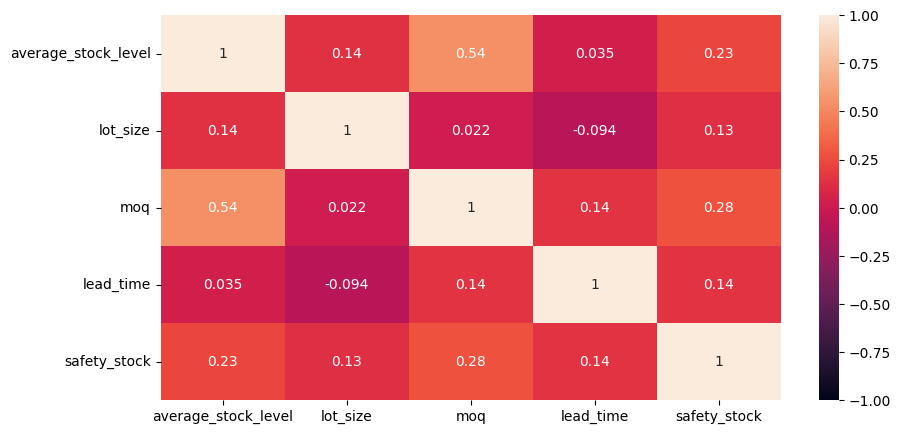

In [24]:
plt.figure(figsize=(10,5))
sns.heatmap(dataset[[ 'average_stock_level', 'lot_size', 'moq','lead_time', 'safety_stock' ]].corr(),vmin=-1,annot= True)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming you have a DataFrame named 'dataset' containing the relevant columns

# Create a DataFrame with the selected variables
selected_vars = dataset[['lot_size', 'moq', 'consumption', 'lead_time']]

# Calculate the VIF for each variable
vif = pd.DataFrame()
vif["Variable"] = selected_vars.columns
vif["VIF"] = [variance_inflation_factor(selected_vars.values, i) for i in range(selected_vars.shape[1])]

# Display the VIF values
print(vif)